### Importing Libraries

In [125]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 300)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from textblob import TextBlob
import re
from wordcloud import WordCloud, STOPWORDS
import string

from nltk.corpus import stopwords

from nltk.corpus import wordnet
from nltk.stem import PorterStemmer,WordNetLemmatizer

import neattext.functions as nf
import warnings
warnings.filterwarnings("ignore")

### Getting Data

In [126]:
data = pd.read_csv('Data/apple_iphone_11_reviews.csv')

In [127]:
data.head()

,product,helpful_count,total_comments,review_country,reviewed_at,review_text,Review rating out of 5,review_title
0,Apple iPhone XR (64GB) - Black,"5,087",24,India,12/12/18,NOTE:,3,"Which iPhone you should Purchase ? iPhone 8, X, XS, XR ?"
1,Apple iPhone XR (64GB) - Black,"2,822",6,India,11/17/18,Very bad experience with this iPhone xr phone. Back camera found defective and non functional. Amazon is very careless. I haven't got any response on confirmation for replacing. I am just hanging with a damaged piece worth of more than 91000 rupees.,1,Don't buy iPhone xr from Amazon.
2,Apple iPhone XR (64GB) - Black,"1,798",0,India,1/27/19,Amazing phone with amazing camera coming from iPhone 7 plus great service from amazon,5,Happy with the purchase
3,Apple iPhone XR (64GB) - Black,"1,366",14,India,5/2/19,"So I got the iPhone XR just today. The product looks amazing. But unfortunately the Face ID is not working and there’s a glitch in the front camera’s portrait mode. That’s fine, it may happen. But what’s not fine is the pathetic service provided by amazon and apple. Firstly, amazon takes no resp...",1,Amazon is not an apple authorised reseller. Please take a note.
4,Apple iPhone XR (64GB) - Black,536,5,India,5/24/19,I've been an android user all my life until I decided to try iPhone XR for iOS. Loving the camera and battery life is an absolute joy to have. It's been more than one month since I got this phone and I'm loving it. Face ID works flawlessly even in the dark and the dual sim function is working li...,5,Excellent Battery life and buttery smooth UI


### Preliminary Analysis

In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5010 entries, 0 to 5009
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   product                 5010 non-null   object
 1   helpful_count           5010 non-null   object
 2   total_comments          5010 non-null   int64 
 3   review_country          5010 non-null   object
 4   reviewed_at             5010 non-null   object
 5   review_text             5007 non-null   object
 6   Review rating out of 5  5010 non-null   int64 
 7   review_title            5008 non-null   object
dtypes: int64(2), object(6)
memory usage: 313.3+ KB


In [129]:
data.rename(columns={'Review rating out of 5': 'rating'},inplace=True)
data['helpful_count'] = data['helpful_count'].str.replace(',', '').astype(int)
data.head()


,product,helpful_count,total_comments,review_country,reviewed_at,review_text,rating,review_title
0,Apple iPhone XR (64GB) - Black,5087,24,India,12/12/18,NOTE:,3,"Which iPhone you should Purchase ? iPhone 8, X, XS, XR ?"
1,Apple iPhone XR (64GB) - Black,2822,6,India,11/17/18,Very bad experience with this iPhone xr phone. Back camera found defective and non functional. Amazon is very careless. I haven't got any response on confirmation for replacing. I am just hanging with a damaged piece worth of more than 91000 rupees.,1,Don't buy iPhone xr from Amazon.
2,Apple iPhone XR (64GB) - Black,1798,0,India,1/27/19,Amazing phone with amazing camera coming from iPhone 7 plus great service from amazon,5,Happy with the purchase
3,Apple iPhone XR (64GB) - Black,1366,14,India,5/2/19,"So I got the iPhone XR just today. The product looks amazing. But unfortunately the Face ID is not working and there’s a glitch in the front camera’s portrait mode. That’s fine, it may happen. But what’s not fine is the pathetic service provided by amazon and apple. Firstly, amazon takes no resp...",1,Amazon is not an apple authorised reseller. Please take a note.
4,Apple iPhone XR (64GB) - Black,536,5,India,5/24/19,I've been an android user all my life until I decided to try iPhone XR for iOS. Loving the camera and battery life is an absolute joy to have. It's been more than one month since I got this phone and I'm loving it. Face ID works flawlessly even in the dark and the dual sim function is working li...,5,Excellent Battery life and buttery smooth UI


In [130]:
data.shape

(5010, 8)

In [131]:
data.duplicated().sum()

np.int64(38)

In [132]:
data.drop_duplicates(inplace=True)
data.isnull().sum()

product           0
helpful_count     0
total_comments    0
review_country    0
reviewed_at       0
review_text       3
rating            0
review_title      2
dtype: int64

In [133]:
data.dropna(inplace=True)
data.shape

(4969, 8)

In [134]:
data.describe()

,helpful_count,total_comments,rating
count,4969.000000,4969.000000,4969.000000
mean,2.946267,0.019924,4.491246
std,89.076844,0.424451,1.082717
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,4.000000
50%,0.000000,0.000000,5.000000
75%,0.000000,0.000000,5.000000
max,5087.000000,24.000000,5.000000


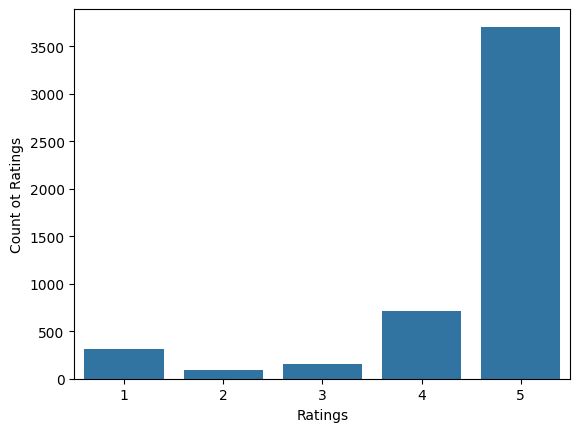

In [135]:
sns.countplot(x='rating', data=data)
plt.xlabel("Ratings")
plt.ylabel("Count ot Ratings")
plt.show()

In [136]:
helpful_rating_group = data.groupby('rating')['helpful_count'].agg(
    helpful_mean_amount='mean',
    helpful_max_amount='max',
    helpful_total_amount='sum',
    count = 'count'
).reset_index()
helpful_rating_group

,rating,helpful_mean_amount,helpful_max_amount,helpful_total_amount,count
0,1,17.079872,2822,5346,313
1,2,1.252874,62,109,87
2,3,34.493421,5087,5243,152
3,4,0.357243,124,254,711
4,5,0.995143,1798,3688,3706


In [137]:
total_comments_rating_group = data.groupby('rating')['total_comments'].agg(
    total_comments_mean_amount='mean',
    total_comments_max_amount='max',
    total_comments_total_amount='sum',
).reset_index()
total_comments_rating_group

,rating,total_comments_mean_amount,total_comments_max_amount,total_comments_total_amount
0,1,0.134185,14,42
1,2,0.022989,1,2
2,3,0.171053,24,26
3,4,0.008439,1,6
4,5,0.006206,5,23


In [138]:
total_comments_rating_group = total_comments_rating_group.merge(helpful_rating_group,how='left',on='rating')
total_comments_rating_group

,rating,total_comments_mean_amount,total_comments_max_amount,total_comments_total_amount,helpful_mean_amount,helpful_max_amount,helpful_total_amount,count
0,1,0.134185,14,42,17.079872,2822,5346,313
1,2,0.022989,1,2,1.252874,62,109,87
2,3,0.171053,24,26,34.493421,5087,5243,152
3,4,0.008439,1,6,0.357243,124,254,711
4,5,0.006206,5,23,0.995143,1798,3688,3706


### Cleaning Data

In [139]:
#cleaning the data from unnecessary data

#replacing url with string URL
def replace_url(text):
    return re.sub('https?:\/\/\S*|www\.\S+','URL',text)

#removing html
def remove_html(text):
    return re.sub('<.*?>','',text)

#replacing mentions with string user
def replace_mentions(text):
    return re.sub('@\S*','user',text,flags=re.IGNORECASE)

#replacing numbers with string number
def replace_num(text):
    return re.sub('^[+-]*?\d{1,3}[- ]*?\d{1,10}|\d{10}','NUMBER',text)

#replacing <3 with sring heart
def replace_heart(text):
    return re.sub('<3','HEART', text)

#removing alphanumeric characters eg-XYZ123ABC
def remove_alphanumeric(text):
    return re.sub('\w*\d+\w*','',text)

#removing all english stopwords 
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

#removing punctuations
def remove_punctuations(text):
    text=''.join([word for word in text if word not in string.punctuation])
    return text

#reducing words to thier root form
def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

In [140]:
def clean_text(text):
    text=str(text).lower()
    text = replace_url(text)
    text = remove_html(text)
    text = replace_mentions(text)
    text = replace_num(text)
    text = replace_heart(text)
    text = remove_alphanumeric(text)
    text = remove_stopwords(text)
    text=remove_punctuations(text)
    #text=stemming(text)
    text=lemmatization(text)
    return text

In [141]:
data['review_text']=data['review_text'].apply(clean_text)
data['review_title']=data['review_title'].apply(clean_text)

### Sentiment Analyis

#### Textblob

In [142]:
data_textblob = data.copy()

In [143]:
polarity = []
subjectivity = []
for i in data_textblob['review_text'].values:
    try:
        analysis = TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
    except:
        polarity.append(0)
        subjectivity.append(0)

In [144]:
data_textblob['polarity'] = polarity
data_textblob['subjectivity'] = subjectivity

In [145]:
data_textblob.head()

,product,helpful_count,total_comments,review_country,reviewed_at,review_text,rating,review_title,polarity,subjectivity
0,Apple iPhone XR (64GB) - Black,5087,24,India,12/12/18,note,3,iphone purchase iphone x xs xr,0.000000,0.000000
1,Apple iPhone XR (64GB) - Black,2822,6,India,11/17/18,bad experience iphone xr phone back camera find defective non functional amazon careless get response confirmation replace hang damage piece worth rupees,1,buy iphone xr amazon,-0.225000,0.416667
2,Apple iPhone XR (64GB) - Black,1798,0,India,1/27/19,amaze phone amaze camera come iphone plus great service amazon,5,happy purchase,0.800000,0.750000
3,Apple iPhone XR (64GB) - Black,1366,14,India,5/2/19,get iphone xr today product look amaze unfortunately face id work there’s glitch front camera’s portrait mode that’s fine may happen what’s fine pathetic service provide amazon apple firstly amazon take responsibility product sell talk giant apple call market leaders go service centre run diagno...,1,amazon apple authorise reseller please take note,-0.040043,0.683983
4,Apple iPhone XR (64GB) - Black,536,5,India,5/24/19,android user life decide try iphone xr ios love camera battery life absolute joy have one month since get phone love it face id work flawlessly even dark dual sim function work like charm use vodafone primary sim jio esim face problem whatsoever,5,excellent battery life buttery smooth ui,0.464286,0.600000


In [146]:
data_textblob.polarity.describe()

count    4969.000000
mean        0.460785
std         0.385827
min        -1.000000
25%         0.097396
50%         0.500000
75%         0.700000
max         1.000000
Name: polarity, dtype: float64

<Axes: >

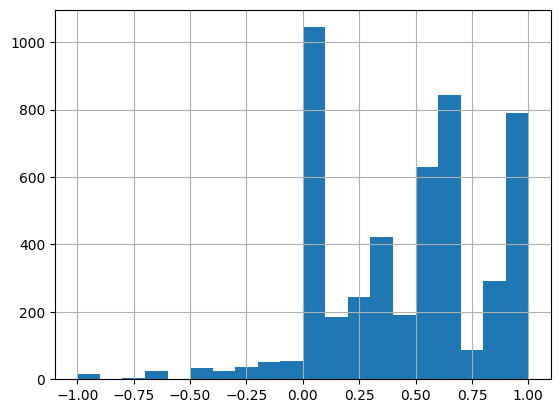

In [147]:
data_textblob.polarity.hist(bins=20)

In [ ]:
bins = np.linspace(-1, 1, 6) 
data_textblob['updated_rating'] = np.clip(np.digitize(data_textblob.polarity, bins, right=False), 1, 5)
data_textblob['diff'] = data_textblob['updated_rating'] - data_textblob['rating']
data_textblob['diff'].value_counts().sort_index()

In [149]:
data_textblob.head()

,product,helpful_count,total_comments,review_country,reviewed_at,review_text,rating,review_title,polarity,subjectivity,updated_rating
0,Apple iPhone XR (64GB) - Black,5087,24,India,12/12/18,note,3,iphone purchase iphone x xs xr,0.000000,0.000000,3
1,Apple iPhone XR (64GB) - Black,2822,6,India,11/17/18,bad experience iphone xr phone back camera find defective non functional amazon careless get response confirmation replace hang damage piece worth rupees,1,buy iphone xr amazon,-0.225000,0.416667,2
2,Apple iPhone XR (64GB) - Black,1798,0,India,1/27/19,amaze phone amaze camera come iphone plus great service amazon,5,happy purchase,0.800000,0.750000,5
3,Apple iPhone XR (64GB) - Black,1366,14,India,5/2/19,get iphone xr today product look amaze unfortunately face id work there’s glitch front camera’s portrait mode that’s fine may happen what’s fine pathetic service provide amazon apple firstly amazon take responsibility product sell talk giant apple call market leaders go service centre run diagno...,1,amazon apple authorise reseller please take note,-0.040043,0.683983,3
4,Apple iPhone XR (64GB) - Black,536,5,India,5/24/19,android user life decide try iphone xr ios love camera battery life absolute joy have one month since get phone love it face id work flawlessly even dark dual sim function work like charm use vodafone primary sim jio esim face problem whatsoever,5,excellent battery life buttery smooth ui,0.464286,0.600000,4


diff
-4       5
-3      31
-2     841
-1    1359
 0    2040
 1     398
 2     230
 3      46
 4      19
Name: count, dtype: int64

#### VADER

In [160]:
data_vader = data.copy()

In [163]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [164]:
def vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # Compound score summarizes overall sentiment in [-1,1]
    compound = scores['compound']
    if compound >= 0.05:
        sentiment = "Positive"
    elif compound <= -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    return pd.Series([sentiment, compound])

# Apply VADER sentiment analysis to DataFrame
data_vader[['Sentiment', 'Compound_Score']] = data_vader['review_text'].apply(vader_sentiment)

In [166]:
data_vader.head()

,product,helpful_count,total_comments,review_country,reviewed_at,review_text,rating,review_title,Sentiment,Compound_Score
0,Apple iPhone XR (64GB) - Black,5087,24,India,12/12/18,note,3,iphone purchase iphone x xs xr,Neutral,0.0000
1,Apple iPhone XR (64GB) - Black,2822,6,India,11/17/18,bad experience iphone xr phone back camera find defective non functional amazon careless get response confirmation replace hang damage piece worth rupees,1,buy iphone xr amazon,Negative,-0.8591
2,Apple iPhone XR (64GB) - Black,1798,0,India,1/27/19,amaze phone amaze camera come iphone plus great service amazon,5,happy purchase,Positive,0.9153
3,Apple iPhone XR (64GB) - Black,1366,14,India,5/2/19,get iphone xr today product look amaze unfortunately face id work there’s glitch front camera’s portrait mode that’s fine may happen what’s fine pathetic service provide amazon apple firstly amazon take responsibility product sell talk giant apple call market leaders go service centre run diagno...,1,amazon apple authorise reseller please take note,Positive,0.8176
4,Apple iPhone XR (64GB) - Black,536,5,India,5/24/19,android user life decide try iphone xr ios love camera battery life absolute joy have one month since get phone love it face id work flawlessly even dark dual sim function work like charm use vodafone primary sim jio esim face problem whatsoever,5,excellent battery life buttery smooth ui,Positive,0.9477


<Axes: >

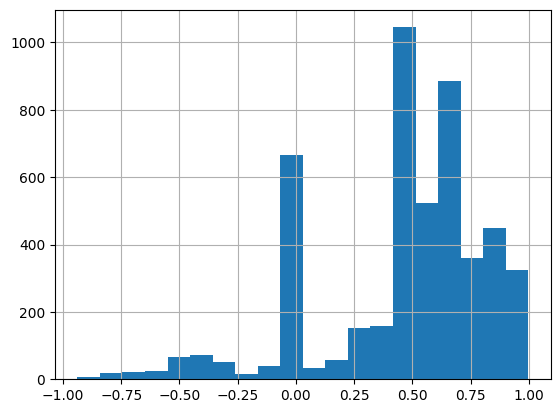

In [168]:
data_vader.Compound_Score.hist(bins=20)

In [169]:
data_vader.Sentiment.value_counts()

Sentiment
Positive    3984
Neutral      661
Negative     324
Name: count, dtype: int64

In [171]:
data_vader['updated_rating'] = np.clip(np.digitize(data_vader.Compound_Score, bins, right=False), 1, 5)
data_vader['diff'] = data_vader['updated_rating'] - data_vader['rating']
data_vader['diff'].value_counts().sort_index()

diff
-4       5
-3      57
-2     492
-1    1614
 0    2159
 1     423
 2     128
 3      69
 4      22
Name: count, dtype: int64

#### RoBERTa

In [175]:
data_RoBERTa = data.copy()

In [172]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

In [173]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
labels = ['Negative', 'Neutral', 'Positive']

def analyze_sentiment(text):
    encoded = tokenizer(text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        output = model(**encoded)
    scores = output.logits[0].numpy()
    probs = softmax(scores)
    sentiment = labels[probs.argmax()]
    confidence = probs.max()
    return sentiment, confidence

In [177]:
data_RoBERTa[['Sentiment', 'Compound_Score']] = data_RoBERTa['review_text'].apply(lambda x: pd.Series(analyze_sentiment(x)))
data_RoBERTa.head()


,product,helpful_count,total_comments,review_country,reviewed_at,review_text,rating,review_title,Sentiment,Compound_Score
0,Apple iPhone XR (64GB) - Black,5087,24,India,12/12/18,note,3,iphone purchase iphone x xs xr,Neutral,0.596637
1,Apple iPhone XR (64GB) - Black,2822,6,India,11/17/18,bad experience iphone xr phone back camera find defective non functional amazon careless get response confirmation replace hang damage piece worth rupees,1,buy iphone xr amazon,Negative,0.923555
2,Apple iPhone XR (64GB) - Black,1798,0,India,1/27/19,amaze phone amaze camera come iphone plus great service amazon,5,happy purchase,Positive,0.968462
3,Apple iPhone XR (64GB) - Black,1366,14,India,5/2/19,get iphone xr today product look amaze unfortunately face id work there’s glitch front camera’s portrait mode that’s fine may happen what’s fine pathetic service provide amazon apple firstly amazon take responsibility product sell talk giant apple call market leaders go service centre run diagno...,1,amazon apple authorise reseller please take note,Neutral,0.461643
4,Apple iPhone XR (64GB) - Black,536,5,India,5/24/19,android user life decide try iphone xr ios love camera battery life absolute joy have one month since get phone love it face id work flawlessly even dark dual sim function work like charm use vodafone primary sim jio esim face problem whatsoever,5,excellent battery life buttery smooth ui,Positive,0.946619


<Axes: >

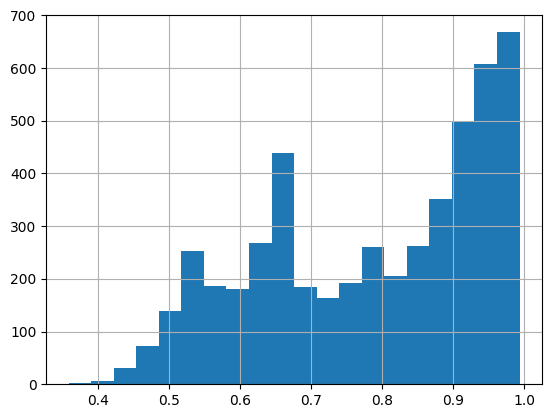

In [178]:
data_RoBERTa.Compound_Score.hist(bins=20)

In [179]:
data_RoBERTa.Sentiment.value_counts()

Sentiment
Positive    3477
Neutral     1206
Negative     286
Name: count, dtype: int64

In [180]:
bins = np.linspace(0, 1, 6) 
data_RoBERTa['updated_rating'] = np.clip(np.digitize(data_RoBERTa.Compound_Score, bins, right=False), 1, 5)
data_RoBERTa['diff'] = data_RoBERTa['updated_rating'] - data_RoBERTa['rating']
data_RoBERTa['diff'].value_counts().sort_index()

diff
-3       1
-2     521
-1    1218
 0    2371
 1     437
 2     168
 3     149
 4     104
Name: count, dtype: int64

#### Zero-Shot Classification

In [185]:
data_zero = data.copy()

In [187]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
data_zero = data_zero[data_zero['review_text'].str.strip().ne("")]

candidate_labels = ["Positive", "Negative", "Neutral"]

results = [classifier(text, candidate_labels) for text in data_zero.review_text]

Device set to use cpu


In [188]:
data_zero['Predicted_Sentiment'] = [res['labels'][0] for res in results]
data_zero['Confidence_score'] = [res['scores'][0] for res in results]

<Axes: >

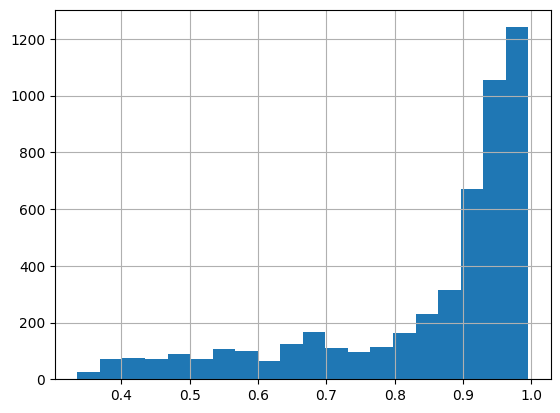

In [189]:
data_zero.Confidence_score.hist(bins=20)

In [190]:
data_zero.Predicted_Sentiment.value_counts()

Predicted_Sentiment
Positive    4141
Negative     735
Neutral       87
Name: count, dtype: int64

In [191]:
bins = np.linspace(0, 1, 6) 
data_zero['updated_rating'] = np.clip(np.digitize(data_zero.Confidence_score, bins, right=False), 1, 5)
data_zero['diff'] = data_zero['updated_rating'] - data_zero['rating']
data_zero['diff'].value_counts().sort_index()

diff
-3      50
-2     340
-1     572
 0    2995
 1     567
 2     159
 3      96
 4     184
Name: count, dtype: int64